### Matching CPS observations over time

##### Example with flow from disability to work

---

January 14, 2019

Brian Dew, @bd_econ

---

Example uses CPS microdata that has already been cleaned and saved as feather format files, to calculate what percent of people age 25 to 54 who were not working the year before due to disability but are employed in the current month. 

In [1]:
# Import packages and set preliminaries
%matplotlib inline

import pandas as pd
import numpy as np
import os
from pathlib import Path

os.chdir('/home/brian/Documents/CPS/')

cps_dir = Path('/home/brian/Documents/CPS/data/clean/')

In [2]:
def cps_1mo(cps_dir, cps_dt, cols):
    '''
    Return 1 month of bd_CPS variables cols ending cps_dt
    '''

    if 'MONTH' not in cols:
        cols = cols + ['MONTH']
    if 'YEAR' not in cols:
        cols = cols + ['YEAR']

    cps_year = cps_dt.year
    cps_month = cps_dt.month
    df = (pd.read_feather(cps_dir / f'cps{cps_year}.ft', columns=cols)
                .query('MONTH == @cps_month'))
        
    return df

In [3]:
cols = ['CPSID', 'AGE', 'FEMALE', 'WBHAO', 'NILFREASON', 
        'LFS', 'MIS', 'BASICWGT', 'LINENO']

emp = lambda x: np.where(x.LFS_y == 'Employed', 1, 0)

dates = pd.date_range('1997-01-01', '2021-03-01', freq='MS')

d = {}

for dt in dates:
    df1 = (cps_1mo(cps_dir, dt - pd.DateOffset(years=1), cols)
           .query('NILFREASON == "Disabled/Ill"'))
    df2 = cps_1mo(cps_dir, dt, cols)
    data = (pd.merge(df1, df2, on=['CPSID', 'LINENO', 'FEMALE', 'WBHAO'])
              .query('25 <= AGE_y <= 54'))
    data = (data.loc[(data.AGE_x <= data.AGE_y) & 
                     (data.AGE_y - 2 <= data.AGE_x)]).assign(EMP = emp)

    d[dt] = np.average(data.EMP, weights=data.BASICWGT_y) * 100
    
df = pd.Series(d).rolling(12).mean().dropna().rename('Share')

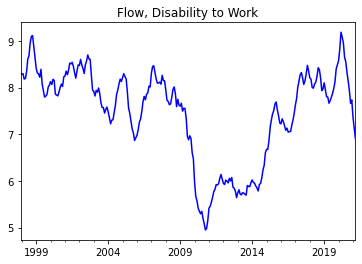

In [4]:
df.plot(color='blue', legend=None, title='Flow, Disability to Work');